In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np

In [5]:
# Load results
with open('./data/GroundTruth/prediction_results.json', 'r') as f:
    samples = json.load(f)

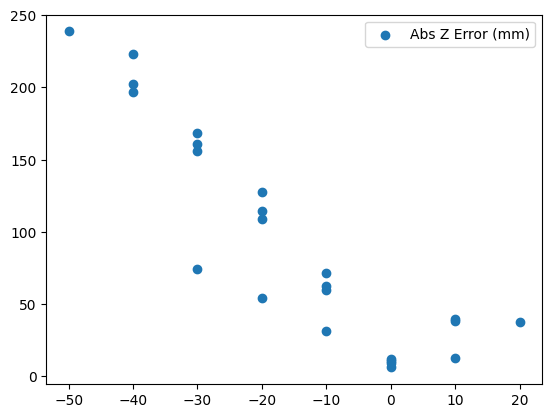

In [6]:
tz_ground_truths = []
tz_predictions = []
tz_errors = []
mount_angles = []
for sample in samples:
    if sample['prediction_translation'] == 'prediction error':
        continue
    ground_truth_tz = sample["ground_truth_translation"][2]
    prediction_tz = sample["prediction_translation"][2]
    mount_angle = sample["measured_angle_mount"]
    mount_angles.append(mount_angle)
    tz_ground_truths.append(ground_truth_tz)
    tz_predictions.append(prediction_tz)
    tz_errors.append(np.abs(prediction_tz - ground_truth_tz))

plt.scatter(mount_angles, tz_errors, marker='o', label='Abs Z Error (mm)')
#plt.scatter(mount_angles, tz_predictions, marker='o', label='predictions')
plt.legend()
plt.show()